# Simple VGG16

Check the devices available. Note you need to have the right version (as in CPU vs GPU version) of TensorFlow installed to harnes the GPU. 

## Paths and Data Splitting
<p style='color: red; font-weight: bold;'>Remember to the paths of the directory and that the directory has files!</p>

Specify the training sizes here. If `train_split` is <= 1 the training and validation datasets will be split based on that decimal value. Otherwise, the training dataset will be a _fixed number of samples_ from the whole dataset and the validation dataset will be some fraction of that. e.g: 

```py
# example 1
train_split = 10000
len(train_paths) # 10000
len(valid_paths) # 2000 (assuming valid_split is 0.2)

# example 2
train_split = 0.80
len(train_paths) # 49262, (80%)
len(valid_paths) # 12316, (20%)
``` 

In [5]:
batch_size = 16    # used much later.
train_split = 0.95
valid_split = 0.2  # used only if train_split > 1

In [6]:
import glob
import pandas as pd
import numpy as np

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(target + '/*.jpg')

data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1_106'
all_files = pd.DataFrame(load_img_paths(original_data_dir))

all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac][0].values.tolist()
    valid_paths = all_files[frac:][0].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split][0].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac][0].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    58499
Validation images: 3079


In [7]:
df = pd.read_csv(data_dir + '/training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [9]:
y_map = {}
for ind, row in df.iterrows():
    _id = int(row['GalaxyID'])
    y_map[_id] = row[1:]

37

In [15]:
y_map[100053]

Class1.1     0.765717
Class1.2     0.177352
Class1.3     0.056931
Class2.1     0.000000
Class2.2     0.177352
Class3.1     0.000000
Class3.2     0.177352
Class4.1     0.000000
Class4.2     0.177352
Class5.1     0.000000
Class5.2     0.117790
Class5.3     0.059562
Class5.4     0.000000
Class6.1     0.000000
Class6.2     1.000000
Class7.1     0.000000
Class7.2     0.741864
Class7.3     0.023853
Class8.1     0.000000
Class8.2     0.000000
Class8.3     0.000000
Class8.4     0.000000
Class8.5     0.000000
Class8.6     0.000000
Class8.7     0.000000
Class9.1     0.000000
Class9.2     0.000000
Class9.3     0.000000
Class10.1    0.000000
Class10.2    0.000000
Class10.3    0.000000
Class11.1    0.000000
Class11.2    0.000000
Class11.3    0.000000
Class11.4    0.000000
Class11.5    0.000000
Class11.6    0.000000
Name: 2, dtype: float64

## Build Model
The path cells above are necessary to run before building the model, as we automatically pass the input shape to the model builder.

In [12]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.app.flags.DEFINE_integer('batch_size', 16, "Batch size.")
tf.app.flags.DEFINE_integer('num_batches', 100, "Number of batches to run.")

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6821092522752324269
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3501178880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5111823010001275079
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [5]:
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import Sequential, Model

def ConvBlock(layers, model, num_filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers):
#         model.add(ZeroPadding2D((1,1))) # zero padding of size 1
        model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same')) # 3x3 filter size 
        
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_first'))

def FCBlock(model, size=4096):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(size, activation='relu'))
    model.add(Dropout(0.5))
    
def my_VGG16(input_shape):
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=input_shape))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)

    model.add(Dense(37, activation = 'sigmoid'))
    return model

Using TensorFlow backend.


In [6]:
from keras.optimizers import RMSprop
from skimage.io import imread

im_shape = imread(train_paths[0]).T.shape

# Then create the corresponding model 
my_model = my_VGG16(im_shape)
optimizer = RMSprop(lr=1e-6)
my_model.compile(loss='mean_squared_error', optimizer=optimizer)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 106, 106)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 106, 64)        61120     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 106, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 53, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 53, 128)        36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 53, 128)        147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 26, 64)         0         
__________

## Training

In [25]:
from os import path

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        print(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Will output sequence of tuples (image, test) given a datapath
def fetch_images(paths, batch_size=32):
    while 1: # while 1 makes it loop around when outerloop finishes
        for i in range(0,len(paths),batch_size):
            X = np.zeros(shape=(batch_size, im_shape[0], im_shape[1], im_shape[2]))
            y = np.zeros(shape=(batch_size, 37))
            for j in range(batch_size):
                ind = (i+j) % len(paths)
                fname = paths[ind]
                # load image from preprocessed images, much faster this way.
                image = imread(fname).T
                X[j] = img_to_array(image)
                file_id = path.split(fname)[-1] \
                              .split('.')[0]
                file_id = int(file_id)
                y[j] = y_map[file_id]
            yield (X, y)
        
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)

# history function
history = LossHistory()

tmp directory already exists


In [26]:
steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Traning images:    58499
Validation images: 3079
Training steps:    3656
Validation steps:  192


In [27]:
hist = my_model.fit_generator(fetch_images(train_paths, batch_size),
    steps_per_epoch=steps_per_epoch, 
    epochs=50,
    validation_data=fetch_images(valid_paths, batch_size),
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[history,checkpointer,early_stopping]
)

Epoch 1/50
 - 300s - loss: 0.0223 - val_loss: 0.0200

Epoch 00001: val_loss improved from inf to 0.01999, saving model to tmp/weights.hdf5
Epoch 2/50
 - 259s - loss: 0.0203 - val_loss: 0.0188

Epoch 00002: val_loss improved from 0.01999 to 0.01875, saving model to tmp/weights.hdf5
Epoch 3/50
 - 256s - loss: 0.0190 - val_loss: 0.0177

Epoch 00003: val_loss improved from 0.01875 to 0.01772, saving model to tmp/weights.hdf5
Epoch 4/50
 - 256s - loss: 0.0181 - val_loss: 0.0170

Epoch 00004: val_loss improved from 0.01772 to 0.01703, saving model to tmp/weights.hdf5
Epoch 5/50
 - 256s - loss: 0.0173 - val_loss: 0.0166

Epoch 00005: val_loss improved from 0.01703 to 0.01660, saving model to tmp/weights.hdf5
Epoch 6/50
 - 256s - loss: 0.0167 - val_loss: 0.0164

Epoch 00006: val_loss improved from 0.01660 to 0.01637, saving model to tmp/weights.hdf5
Epoch 7/50
 - 256s - loss: 0.0163 - val_loss: 0.0162

Epoch 00007: val_loss improved from 0.01637 to 0.01620, saving model to tmp/weights.hdf5
Epo

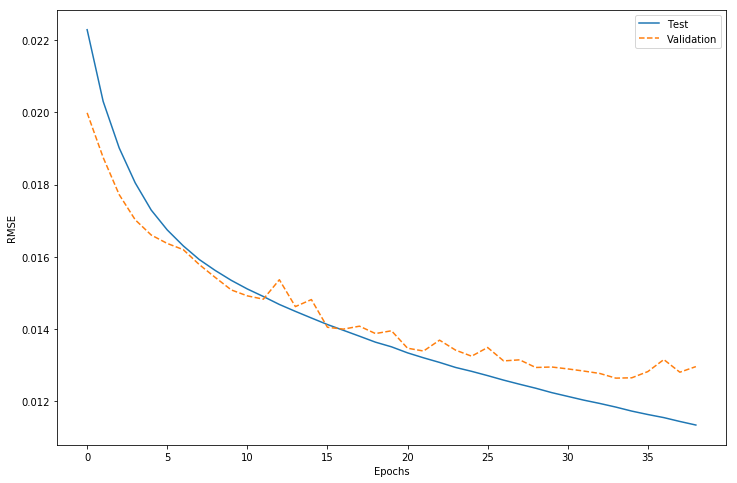

In [28]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()